In [2]:
# ============================== #
#       1. 匯入必要的套件 + CUDA測試  #
# ============================== #

import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from tqdm import tqdm

# 機器學習、模型相關
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# XGBoost / LightGBM / CatBoost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# 繪圖相關
import matplotlib.pyplot as plt

# 設定顯示選項
pd.set_option('display.max_columns', None)

# 簡單的 CUDA 測試
print("===================================")
print("        CUDA 測試程式碼開始        ")
print("===================================")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 驅動版本: {torch.version.cuda}")
    print(f"CUDA CUDNN 版本: {torch.backends.cudnn.version()}")
    print(f"CUDA 設備數量: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA 設備 {i}: {torch.cuda.get_device_name(i)}")
    print(f"當前使用的 CUDA 設備: {torch.cuda.current_device()}")
else:
    print("CUDA 不可用。請檢查：1. GPU 驅動，2. CUDA Toolkit 版本，3. PyTorch 安裝版本…")

print("===================================")
print("          CUDA 測試程式碼結束       ")
print("===================================")


        CUDA 測試程式碼開始        
PyTorch 版本: 2.6.0.dev20241221+cu126
CUDA 可用: True
CUDA 驅動版本: 12.6
CUDA CUDNN 版本: 90501
CUDA 設備數量: 1
CUDA 設備 0: NVIDIA GeForce RTX 3050 Laptop GPU
當前使用的 CUDA 設備: 0
          CUDA 測試程式碼結束       


In [3]:
# ============================== #
# 2. 定義新聞資料處理與清理 + 輔助函數 #
# ============================== #

def clean_text(txt: str) -> str:
    """簡單文本清理，去除多餘空白和雜訊。"""
    if not isinstance(txt, str):
        return ""
    txt = re.sub(r'\s+', ' ', txt)
    return txt.strip()

def parse_cnbc_time(t):
    """解析 CNBC 的時間格式: '7:51 PM ET Fri, 17 July 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t, '%I:%M %p ET %a, %d %B %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_guardian_time(t):
    """解析 Guardian 的時間格式: '18-Jul-20'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%d-%b-%y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_reuters_time(t):
    """解析 Reuters 的時間格式: 'Jul 18 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%b %d %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def load_cnbc(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: CNBC CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_cnbc_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'CNBC'
    return df

def load_guardian(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Time', 'Headlines']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Guardian CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = ""  # Guardian 無 Description
    df['date'] = df['Time'].apply(parse_guardian_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Guardian'
    return df

def load_reuters(csv_path: str) -> pd.DataFrame:
    # 如果報 ParserError，請視情況調整 on_bad_lines='skip'、sep=',' 等
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Reuters CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_reuters_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Reuters'
    return df

def load_cnn_articles(base_dir: str) -> pd.DataFrame:
    """
    載入所有 CNN 文章，並整理成 DataFrame。
    
    Parameters:
        base_dir (str): CNN 文章的基礎資料夾路徑。
        
    Returns:
        pd.DataFrame: 包含 'date', 'headline', 'article_content', 'source' 的 DataFrame。
    """
    records = []
    for date_folder in os.listdir(base_dir):
        date_path = os.path.join(base_dir, date_folder)
        if os.path.isdir(date_path):
            for file_name in os.listdir(date_path):
                if file_name.endswith('.txt'):
                    file_path = os.path.join(date_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        content = clean_text(content)
                        if content:  # 確保內容非空
                            records.append({
                                'date': date_folder,  # 假設資料夾名稱即為日期
                                'headline': "",  # CNN 資料無標題，設為空字串
                                'article_content': content,
                                'source': 'CNN'
                            })
    df_cnn = pd.DataFrame(records)
    df_cnn['date'] = pd.to_datetime(df_cnn['date'], errors='coerce')
    df_cnn = df_cnn.dropna(subset=['date'])
    df_cnn['date'] = df_cnn['date'].dt.strftime('%Y-%m-%d')
    return df_cnn

def merge_news(cnbc_csv, guardian_csv, reuters_csv, cnn_articles_dir):
    """
    讀取並合併 CNBC、Guardian、Reuters 和 CNN 的新聞資料。
    """
    cnbc_df = load_cnbc(cnbc_csv)
    guardian_df = load_guardian(guardian_csv)
    reuters_df = load_reuters(reuters_csv)
    cnn_df = load_cnn_articles(cnn_articles_dir)

    df_news = pd.concat([cnbc_df, guardian_df, reuters_df, cnn_df], ignore_index=True)
    df_news['date'] = pd.to_datetime(df_news['date'])
    df_news.sort_values('date', inplace=True)
    df_news.reset_index(drop=True, inplace=True)
    return df_news

def setup_finbert_pipeline():
    """初始化 FinBERT pipeline"""
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    device = 0 if torch.cuda.is_available() else -1
    finbert_pipeline = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print(f"FinBERT pipeline 使用的設備: {'GPU (0)' if device == 0 else 'CPU'}")
    return finbert_pipeline

def batch_sentiment(text_list, pipeline_fn, batch_size=16, max_length=128):
    """
    手動分批，並使用 tqdm 進度條顯示處理進度。
    """
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis Batches"):
        batch_texts = text_list[i:i+batch_size]
        try:
            batch_out = pipeline_fn(
                batch_texts,
                truncation=True,
                max_length=max_length
            )
            for out in batch_out:
                label = out['label'].lower()
                score = out['score']
                if label == 'positive':
                    results.append(+score)
                elif label == 'negative':
                    results.append(-score)
                else:
                    results.append(0.0)
        except Exception as e:
            print(f"批次 {i//batch_size + 1} 解析錯誤: {e}")
            results.extend([0.0]*len(batch_texts))
    return results

def compute_daily_sentiment(df_news: pd.DataFrame, sentiment_pipeline, batch_size=16, max_length=128) -> pd.DataFrame:
    """
    對 headline & article_content 做批次情緒分析，並彙整成每日平均分數。
    """
    print("開始批次情緒分析 (FinBERT) ...")

    # headline
    headlines = df_news['headline'].tolist()
    print("-> 分析 Headline")
    headline_scores = batch_sentiment(headlines, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    # content
    contents = df_news['article_content'].tolist()
    print("-> 分析 Content")
    content_scores = batch_sentiment(contents, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    df_news['headline_sent'] = headline_scores
    df_news['content_sent']  = content_scores

    print("-> 彙整當日情緒...")
    daily_sentiment = (
        df_news
        .groupby('date')
        .agg({'headline_sent':'mean','content_sent':'mean'})
        .reset_index()
        .rename(columns={
            'headline_sent': 'mean_headline_sent',
            'content_sent': 'mean_content_sent'
        })
    )
    print("情緒分析完成。若出現負值，代表負面新聞居多。")
    return daily_sentiment

def load_sp500(sp_csv_path: str) -> pd.DataFrame:
    df_sp = pd.read_csv(sp_csv_path, on_bad_lines='skip', engine='python')
    df_sp.rename(columns={'Date':'date','S&P500':'sp_close'}, inplace=True)
    # 保持 date 為 datetime64[ns]
    df_sp['date'] = pd.to_datetime(df_sp['date'])
    df_sp.sort_values('date', inplace=True)
    return df_sp

def create_labels_for_prediction(df: pd.DataFrame, mode='classification'):
    """
    mode='classification': 隔日漲(1)/跌(0)
    mode='regression': 預測隔日收盤價
    """
    df['sp_close_next'] = df['sp_close'].shift(-1)
    df = df.dropna(subset=['sp_close_next'])
    if mode == 'classification':
        df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)
    else:
        df['target'] = df['sp_close_next']
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    # 移動平均線
    df['MA_5'] = df['sp_close'].rolling(window=5).mean()
    df['MA_10'] = df['sp_close'].rolling(window=10).mean()

    # RSI
    delta = df['sp_close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # MACD
    ema_12 = df['sp_close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['sp_close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']

    # Bollinger Bands
    df['BB_upper'] = df['MA_10'] + 2 * df['sp_close'].rolling(window=10).std()
    df['BB_lower'] = df['MA_10'] - 2 * df['sp_close'].rolling(window=10).std()

    df.dropna(inplace=True)
    return df

def add_sentiment_features(df: pd.DataFrame, sentiment_col='mean_headline_sent', lags=[1,2,3]) -> pd.DataFrame:
    # 情緒變動值
    df['sentiment_change_1'] = df[sentiment_col].diff(1)
    df['sentiment_change_2'] = df[sentiment_col].diff(2)
    df['sentiment_change_3'] = df[sentiment_col].diff(3)
    # 滯後情緒
    for lag in lags:
        df[f'sentiment_lag_{lag}'] = df[sentiment_col].shift(lag)

    df.dropna(inplace=True)
    return df

def add_sp500_features(df: pd.DataFrame, lags=[1,2,3], rolling_window=5) -> pd.DataFrame:
    df['sp_return'] = df['sp_close'].pct_change()
    for lag in lags:
        df[f'sp_return_lag_{lag}'] = df['sp_return'].shift(lag)
    df[f'sp_return_mean_{rolling_window}'] = df['sp_return'].rolling(window=rolling_window).mean()

    for lag in lags:
        df[f'sp_close_lag_{lag}'] = df['sp_close'].shift(lag)

    df.dropna(inplace=True)
    return df

def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = add_technical_indicators(df)
    df = add_sentiment_features(df, sentiment_col='mean_headline_sent', lags=[1,2,3])
    df = add_sp500_features(df, lags=[1,2,3], rolling_window=5)

    if 'date' not in df.columns:
        raise KeyError("'date' 欄位在特徵工程後遺失。")
    return df


In [4]:
# ============================== #
# 3. 定義模型訓練函數 & 交叉驗證      #
# ============================== #

def train_random_forest(X_train, y_train):
    """訓練 Random Forest 模型。"""
    clf = RandomForestClassifier(
        n_estimators=150,
        random_state=42,
        class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    return clf

def train_xgboost(X_train, y_train):
    """訓練 XGBoost 模型，使用 GPU（若可用）。"""
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',
        predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
        gpu_id=0,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_lightgbm(X_train, y_train):
    """訓練 LightGBM 模型，使用 GPU。"""
    device_type = 'gpu' if torch.cuda.is_available() else 'cpu'
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        device=device_type,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=10,
        num_leaves=31,
        min_data_in_leaf=10,
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_catboost(X_train, y_train):
    """訓練 CatBoost 模型，使用 GPU。"""
    task_type = 'GPU' if torch.cuda.is_available() else 'CPU'
    clf = cb.CatBoostClassifier(
        iterations=150,
        learning_rate=0.1,
        depth=5,
        class_weights=[2,1],  # 簡易平衡
        task_type=task_type,
        devices='0',
        verbose=0,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_mlp(X_train, y_train):
    """訓練 MLP 模型 (sklearn 版本)。"""
    clf = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def get_stacking_model():
    """
    建立 Stacking 模型，結合數個已知的分類器 (這裡使用 VotingClassifier 作為示範)。
    """
    est_rf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
    est_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    est_lgbm = lgb.LGBMClassifier(random_state=42)
    est_cb = cb.CatBoostClassifier(iterations=100, verbose=0, random_state=42)

    stacking_clf = VotingClassifier(
        estimators=[
            ('rf', est_rf),
            ('xgb', est_xgb),
            ('lgb', est_lgbm),
            ('cat', est_cb)
        ],
        voting='soft'
    )
    return stacking_clf

def train_stacking(X_train, y_train):
    """訓練 Stacking (這裡實際是 VotingClassifier) 模型。"""
    stacking_clf = get_stacking_model()
    stacking_clf.fit(X_train, y_train)
    return stacking_clf

def evaluate_classification(y_true, y_pred, y_prob=None):
    """評估分類模型。"""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return acc, f1, auc

def timeseries_cv_and_train(X, y, model_fn, n_splits=5):
    """
    使用 TimeSeriesSplit 進行交叉驗證，回傳平均 Accuracy、F1 分數和 AUC-ROC。
    model_fn: 傳入可呼叫 (X_train, y_train) -> (model)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    acc_scores = []
    f1_scores = []
    auc_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold_idx+1}/{n_splits} 開始...")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_, y_val = y[train_idx], y[val_idx]

        print(f"Fold {fold_idx+1} - X_train shape: {X_train.shape}")
        print(f"Fold {fold_idx+1} - X_val shape: {X_val.shape}")
        print(f"Fold {fold_idx+1} - y_train shape: {y_train_.shape}")
        print(f"Fold {fold_idx+1} - y_val shape: {y_val.shape}")

        model = model_fn(X_train, y_train_)
        y_pred = model.predict(X_val)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val)[:,1]
        else:
            y_prob = None

        acc, f1, auc = evaluate_classification(y_val, y_pred, y_prob)
        acc_scores.append(acc)
        f1_scores.append(f1)
        auc_scores.append(auc if auc is not None else 0.0)

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(auc_scores)
    print(f"\n=== TimeSeriesSplit 平均 ACC: {avg_acc:.4f}, F1: {avg_f1:.4f}, AUC-ROC: {avg_auc:.4f} ===")
    return avg_acc, avg_f1, avg_auc

# ======== XGBoost超參數調整範例 ======== #
def train_xgboost_gridsearch(X_train, y_train):
    """
    使用 GridSearchCV 進行超參數調整的 XGBoost。
    """
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'scale_pos_weight': [1, 2, 3]
    }

    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )

    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    return best_model

def train_xgboost_randomsearch(X_train, y_train):
    """
    使用 RandomizedSearchCV 進行超參數調整的 XGBoost。
    """
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }

    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )

    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        n_iter=50,          # 可自行調大
        scoring='accuracy',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

    best_model = random_search.best_estimator_
    return best_model


In [5]:
# ============================== #
# 4. 主流程 (讀取資料, 進行情緒分析, 訓練, 預測, 視覺化) #
# ============================== #

# ============ 4.1 讀取新聞資料 & 進行情緒分析 ============
# 請根據實際路徑修改以下變數
cnbc_csv     = "test/cnbc_headlines.csv"
guardian_csv = "test/guardian_headlines.csv"
reuters_csv  = "test/reuters_headlines.csv"
cnn_articles_dir = "articles_for_business"  # CNN 文章資料夾

# 讀取各個來源的新聞資料
df_cnbc = load_cnbc(cnbc_csv)
print(f"[CNBC] total: {len(df_cnbc)} rows.")

df_guardian = load_guardian(guardian_csv)
print(f"[Guardian] total: {len(df_guardian)} rows.")

df_reuters = load_reuters(reuters_csv)
print(f"[Reuters] total: {len(df_reuters)} rows.")

df_cnn = load_cnn_articles(cnn_articles_dir)
print(f"[CNN] total: {len(df_cnn)} rows.")

# 合併所有新聞資料
df_news = pd.concat([df_cnbc, df_guardian, df_reuters, df_cnn], ignore_index=True)
df_news.sort_values('date', inplace=True)
df_news.reset_index(drop=True, inplace=True)
print(f"[News] total: {len(df_news)} rows from 4 sources.")

# 初始化 FinBERT pipeline
finbert_pipe = setup_finbert_pipeline()

# 執行情緒分析
daily_sentiment_df = compute_daily_sentiment(df_news, finbert_pipe,
                                             batch_size=32, max_length=128)
daily_sentiment_df.to_csv("daily_sentiment.csv", index=False)
print("[Output] daily_sentiment.csv 已輸出.")


[CNBC] total: 119 rows.
[Guardian] total: 17760 rows.
[Reuters] total: 32759 rows.
[CNN] total: 929 rows.
[News] total: 51567 rows from 4 sources.


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


FinBERT pipeline 使用的設備: GPU (0)
開始批次情緒分析 (FinBERT) ...
-> 分析 Headline


Sentiment Analysis Batches:   1%|          | 10/1612 [00:02<06:18,  4.23it/s]c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Sentiment Analysis Batches: 100%|██████████| 1612/1612 [09:39<00:00,  2.78it/s]


-> 分析 Content


Sentiment Analysis Batches: 100%|██████████| 1612/1612 [09:27<00:00,  2.84it/s]

-> 彙整當日情緒...
情緒分析完成。若出現負值，代表負面新聞居多。
[Output] daily_sentiment.csv 已輸出.


In [8]:
# ============ 4.2 讀取 S&P500 資料 ============
sp500_csv    = "test/sp500_index.csv"
df_sp = load_sp500(sp500_csv)
print(f"[SP500] total: {len(df_sp)} rows.")

# ============ 4.3 合併情緒 & 股市資料 + 建標籤 ============
daily_sentiment_df['date'] = pd.to_datetime(daily_sentiment_df['date'], errors='coerce')
df_sp['date'] = pd.to_datetime(df_sp['date'], errors='coerce')

df_merged = pd.merge(daily_sentiment_df, df_sp, on='date', how='inner')
df_merged.sort_values('date', inplace=True)
df_merged.dropna(inplace=True)
df_merged = create_labels_for_prediction(df_merged, mode='classification')

print(f"[Merged Data] shape={df_merged.shape}")

# ============ 4.4 添加所有特徵 ============
df_merged = add_feature_engineering(df_merged)
print(f"[Merged Data with Features] shape={df_merged.shape}")

# 特徵列表
features = [
    'mean_headline_sent','mean_content_sent','sp_close',
    'sp_close_lag_1','sp_close_lag_2','sp_close_lag_3',
    'MA_5','MA_10','RSI','MACD','MACD_signal','MACD_diff',
    'BB_upper','BB_lower','sentiment_change_1','sentiment_change_2','sentiment_change_3',
    'sentiment_lag_1','sentiment_lag_2','sentiment_lag_3',
    'sp_return','sp_return_lag_1','sp_return_lag_2','sp_return_lag_3','sp_return_mean_5'
]

# 確保所有特徵都存在
missing_features = [feat for feat in features if feat not in df_merged.columns]
if missing_features:
    print(f"錯誤: 缺少特徵 {missing_features}")
else:
    print("所有特徵均存在。")

# 填補 NaN 值並確保數據類型正確
df_merged[features] = df_merged[features].astype(float).fillna(0)

X_full = df_merged[features].values
y_full = df_merged['target'].values

# 標準化
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

print("[Info] 特徵標準化完成.")
print(f"X_full_scaled shape: {X_full_scaled.shape}")

# ============ 4.5 交叉驗證測試幾種模型 ============
print("\n=== TimeSeriesSplit: Random Forest ===")
def model_fn_rf(X, y):
    model = train_random_forest(X, y)
    return model
avg_acc_rf, avg_f1_rf, avg_auc_rf = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_rf, n_splits=3
)

print("\n=== TimeSeriesSplit: XGBoost ===")
def model_fn_xgb(X, y):
    model = train_xgboost(X, y)
    return model
avg_acc_xgb, avg_f1_xgb, avg_auc_xgb = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_xgb, n_splits=3
)

print("\n=== TimeSeriesSplit: LightGBM ===")
def model_fn_lgbm(X, y):
    model = train_lightgbm(X, y)
    return model
avg_acc_lgbm, avg_f1_lgbm, avg_auc_lgbm = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_lgbm, n_splits=3
)

print("\n=== TimeSeriesSplit: CatBoost ===")
def model_fn_cat(X, y):
    model = train_catboost(X, y)
    return model
avg_acc_cb, avg_f1_cb, avg_auc_cb = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_cat, n_splits=3
)

print("\n=== TimeSeriesSplit: MLP ===")
def model_fn_mlp_(X, y):
    model = train_mlp(X, y)
    return model
avg_acc_mlp, avg_f1_mlp, avg_auc_mlp = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_mlp_, n_splits=3
)

print("\n=== TimeSeriesSplit: Stacking ===")
def model_fn_stack(X, y):
    model = train_stacking(X, y)
    return model
avg_acc_stack, avg_f1_stack, avg_auc_stack = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_stack, n_splits=3
)

print("\n=== TimeSeriesSplit: XGBoost GridSearch ===")
def model_fn_xgb_grid(X, y):
    model = train_xgboost_gridsearch(X, y)
    return model
avg_acc_xgb_grid, avg_f1_xgb_grid, avg_auc_xgb_grid = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_xgb_grid, n_splits=3
)

print("\n=== TimeSeriesSplit: XGBoost RandomSearch ===")
def model_fn_xgb_rand(X, y):
    model = train_xgboost_randomsearch(X, y)
    return model
avg_acc_xgb_random, avg_f1_xgb_random, avg_auc_xgb_random = timeseries_cv_and_train(
    X_full_scaled, y_full, model_fn=model_fn_xgb_rand, n_splits=3
)

# 挑選測試 ACC 最好的
model_acc = {
    "RandomForest": avg_acc_rf,
    "XGBoost": avg_acc_xgb,
    "LightGBM": avg_acc_lgbm,
    "CatBoost": avg_acc_cb,
    "MLP": avg_acc_mlp,
    "Stacking": avg_acc_stack,
    "XGBoost_GridSearch": avg_acc_xgb_grid,
    "XGBoost_RandomSearch": avg_acc_xgb_random
}
best_model_name = max(model_acc, key=model_acc.get)
best_acc = model_acc[best_model_name]
print(f"\n[Best Model] {best_model_name}, ACC={best_acc:.4f}")

[SP500] total: 2516 rows.
[Merged Data] shape=(898, 6)
[Merged Data with Features] shape=(877, 28)
所有特徵均存在。
[Info] 特徵標準化完成.
X_full_scaled shape: (877, 25)

=== TimeSeriesSplit: Random Forest ===

Fold 1/3 開始...
Fold 1 - X_train shape: (220, 25)
Fold 1 - X_val shape: (219, 25)
Fold 1 - y_train shape: (220,)
Fold 1 - y_val shape: (219,)


C:\Users\morri\AppData\Local\Temp\ipykernel_15200\310771742.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)


Accuracy: 0.4795
F1 Score: 0.3214
AUC-ROC: 0.5321

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.82      0.58        95
           1       0.61      0.22      0.32       124

    accuracy                           0.48       219
   macro avg       0.53      0.52      0.45       219
weighted avg       0.54      0.48      0.43       219


Fold 2/3 開始...
Fold 2 - X_train shape: (439, 25)
Fold 2 - X_val shape: (219, 25)
Fold 2 - y_train shape: (439,)
Fold 2 - y_val shape: (219,)
Accuracy: 0.4384
F1 Score: 0.2890
AUC-ROC: 0.4592

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.76      0.54        93
           1       0.53      0.20      0.29       126

    accuracy                           0.44       219
   macro avg       0.47      0.48      0.41       219
weighted avg       0.48      0.44      0.39       219


Fold 3/3 開始...
Fold 3 - X_train shape: (658, 25)
Fold 3

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 0.4977
F1 Score: 0.3820
AUC-ROC: 0.5548

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.79      0.58        95
           1       0.63      0.27      0.38       124

    accuracy                           0.50       219
   macro avg       0.54      0.53      0.48       219
weighted avg       0.55      0.50      0.47       219


Fold 2/3 開始...
Fold 2 - X_train shape: (439, 25)
Fold 2 - X_val shape: (219, 25)
Fold 2 - y_train shape: (439,)
Fold 2 - y_val shape: (219,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.4840
F1 Score: 0.4021
AUC-ROC: 0.5224

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.73      0.55        93
           1       0.60      0.30      0.40       126

    accuracy                           0.48       219
   macro avg       0.52      0.52      0.47       219
weighted avg       0.53      0.48      0.46       219


Fold 3/3 開始...
Fold 3 - X_train shape: (658, 25)
Fold 3 - X_val shape: (219, 25)
Fold 3 - y_train shape: (658,)
Fold 3 - y_val shape: (219,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling

Accuracy: 0.4384
F1 Score: 0.0752
AUC-ROC: 0.5073

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.96      0.60        95
           1       0.56      0.04      0.08       124

    accuracy                           0.44       219
   macro avg       0.49      0.50      0.34       219
weighted avg       0.50      0.44      0.30       219


=== TimeSeriesSplit 平均 ACC: 0.4734, F1: 0.2864, AUC-ROC: 0.5282 ===

=== TimeSeriesSplit: LightGBM ===

Fold 1/3 開始...
Fold 1 - X_train shape: (220, 25)
Fold 1 - X_val shape: (219, 25)
Fold 1 - y_train shape: (220,)
Fold 1 - y_val shape: (219,)
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 113, number of negative: 107
[LightGBM] [Info] This is the GPU trainer!

Accuracy: 0.4795
F1 Score: 0.3133
AUC-ROC: 0.5338

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.83      0.58        95
           1       0.62      0.21      0.31       124

    accuracy                           0.48       219
   macro avg       0.53      0.52      0.45       219
weighted avg       0.54      0.48      0.43       219


Fold 2/3 開始...
Fold 2 - X_train shape: (439, 25)
Fold 2 - X_val shape: (219, 25)
Fold 2 - y_train shape: (439,)
Fold 2 - y_val shape: (219,)


Accuracy: 0.4612
F1 Score: 0.4040
AUC-ROC: 0.4932

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.66      0.51        93
           1       0.56      0.32      0.40       126

    accuracy                           0.46       219
   macro avg       0.49      0.49      0.46       219
weighted avg       0.50      0.46      0.45       219


Fold 3/3 開始...
Fold 3 - X_train shape: (658, 25)
Fold 3 - X_val shape: (219, 25)
Fold 3 - y_train shape: (658,)
Fold 3 - y_val shape: (219,)


Accuracy: 0.4429
F1 Score: 0.1029
AUC-ROC: 0.4846

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.95      0.60        95
           1       0.58      0.06      0.10       124

    accuracy                           0.44       219
   macro avg       0.51      0.50      0.35       219
weighted avg       0.52      0.44      0.32       219


=== TimeSeriesSplit 平均 ACC: 0.4612, F1: 0.2734, AUC-ROC: 0.5039 ===

=== TimeSeriesSplit: MLP ===

Fold 1/3 開始...
Fold 1 - X_train shape: (220, 25)
Fold 1 - X_val shape: (219, 25)
Fold 1 - y_train shape: (220,)
Fold 1 - y_val shape: (219,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5479
F1 Score: 0.5520
AUC-ROC: 0.5258

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        95
           1       0.63      0.49      0.55       124

    accuracy                           0.55       219
   macro avg       0.56      0.56      0.55       219
weighted avg       0.57      0.55      0.55       219


Fold 2/3 開始...
Fold 2 - X_train shape: (439, 25)
Fold 2 - X_val shape: (219, 25)
Fold 2 - y_train shape: (439,)
Fold 2 - y_val shape: (219,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.4749
F1 Score: 0.5594
AUC-ROC: 0.4510

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.33      0.35        93
           1       0.54      0.58      0.56       126

    accuracy                           0.47       219
   macro avg       0.45      0.46      0.45       219
weighted avg       0.47      0.47      0.47       219


Fold 3/3 開始...
Fold 3 - X_train shape: (658, 25)
Fold 3 - X_val shape: (219, 25)
Fold 3 - y_train shape: (658,)
Fold 3 - y_val shape: (219,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.4292
F1 Score: 0.0310
AUC-ROC: 0.5149

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.97      0.60        95
           1       0.40      0.02      0.03       124

    accuracy                           0.43       219
   macro avg       0.41      0.49      0.31       219
weighted avg       0.41      0.43      0.28       219


=== TimeSeriesSplit 平均 ACC: 0.4840, F1: 0.3808, AUC-ROC: 0.4972 ===

=== TimeSeriesSplit: Stacking ===

Fold 1/3 開始...
Fold 1 - X_train shape: (220, 25)
Fold 1 - X_val shape: (219, 25)
Fold 1 - y_train shape: (220,)
Fold 1 - y_val shape: (219,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 113, number of negative: 107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513636 -> initscore=0.054559
[LightGBM] [Info] Start training from score 0.054559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 237, number of negative: 202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3676
[LightGBM] [Info] Number of data points in the train set: 439, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539863 -> initscore=0.159792
[LightGBM] [Info] Start training from score 0.159792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 363, number of negative: 295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5494
[LightGBM] [Info] Number of data points in the train set: 658, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551672 -> initscore=0.207427
[LightGBM] [Info] Start training from score 0.207427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [9]:
# ============================== #
# 5. 使用最優模型進行最終訓練與測試 #
# ============================== #

# 以 80% 當作訓練集
split_ratio = 0.8
split_index = int(len(df_merged) * split_ratio)

df_train = df_merged.iloc[:split_index].copy()
df_test = df_merged.iloc[split_index:].copy()

X_train_full = X_full[:split_index]
y_train_full = y_full[:split_index]
X_test_full  = X_full[split_index:]
y_test_full  = y_full[split_index:]

# 標準化訓練集與測試集
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_full)
X_test_scaled  = scaler_final.transform(X_test_full)

# SMOTE 處理類別不平衡
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_full)

print(f"重新採樣後訓練集大小: {X_train_resampled.shape[0]}")
print(f"重新採樣後測試集大小: {X_test_scaled.shape[0]}")

# 根據 best_model_name 取得最終模型
def get_best_model(model_name):
    if model_name == "RandomForest":
        return train_random_forest(X_train_resampled, y_train_resampled)
    elif model_name == "XGBoost":
        return train_xgboost(X_train_resampled, y_train_resampled)
    elif model_name == "LightGBM":
        return train_lightgbm(X_train_resampled, y_train_resampled)
    elif model_name == "CatBoost":
        return train_catboost(X_train_resampled, y_train_resampled)
    elif model_name == "MLP":
        return train_mlp(X_train_resampled, y_train_resampled)
    elif model_name == "Stacking":
        return train_stacking(X_train_resampled, y_train_resampled)
    elif model_name == "XGBoost_GridSearch":
        return train_xgboost_gridsearch(X_train_resampled, y_train_resampled)
    elif model_name == "XGBoost_RandomSearch":
        return train_xgboost_randomsearch(X_train_resampled, y_train_resampled)
    else:
        raise ValueError("未知的模型名稱")

final_model = get_best_model(best_model_name)

# 預測
y_pred_test = final_model.predict(X_test_scaled)
y_prob_test = None
if hasattr(final_model, "predict_proba"):
    y_prob_test = final_model.predict_proba(X_test_scaled)[:,1]

def evaluate_final_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print(f"Final Model Accuracy: {acc:.4f}")
    print(f"Final Model F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"Final Model AUC-ROC: {auc:.4f}")

    print("\nFinal Model Classification Report:")
    print(classification_report(y_true, y_pred))

    return acc, f1, auc

acc_test, f1_test, auc_test = evaluate_final_model(y_test_full, y_pred_test, y_prob_test)

# 將最終預測結果加入 df_test
df_test['y_pred'] = y_pred_test


重新採樣後訓練集大小: 768
重新採樣後測試集大小: 176
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 3, 'subsample': 0.7}
Best cross-validation accuracy: 0.5247
Final Model Accuracy: 0.5795
Final Model F1 Score: 0.7040
Final Model AUC-ROC: 0.5450

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.19      0.27        73
           1       0.60      0.85      0.70       103

    accuracy                           0.58       176
   macro avg       0.54      0.52      0.49       176
weighted avg       0.55      0.58      0.53       176



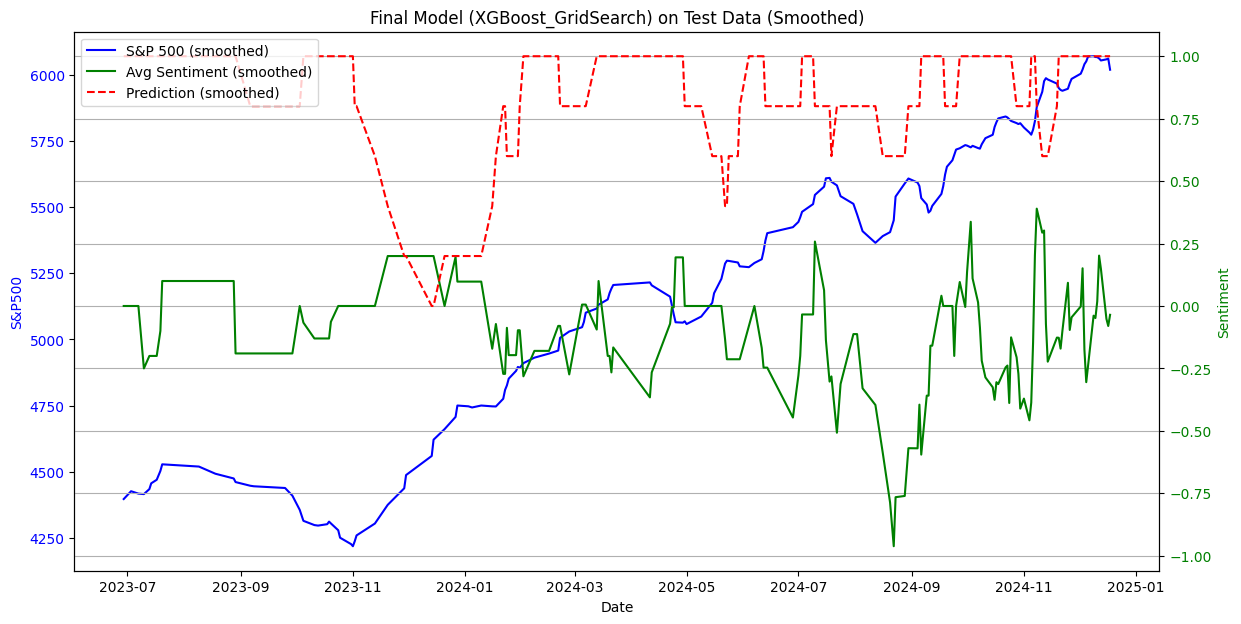

In [13]:
# ============================== #
# 6. 視覺化結果 #
# ============================== #

# 移動平均
def smooth_curve(y, window=5):
    return pd.Series(y).rolling(window=window, min_periods=1).mean().values

df_test['sp_close_smooth'] = smooth_curve(df_test['sp_close'], window=5)
df_test['mean_content_sent_smooth'] = smooth_curve(df_test['mean_content_sent'], window=5)
df_test['y_pred_smooth'] = smooth_curve(df_test['y_pred'], window=5)

# 設定日期為索引（如果尚未設定）
if 'date' in df_test.columns:
    df_test['date'] = pd.to_datetime(df_test['date'])
    df_test.set_index('date', inplace=True)

# 創建一個雙 y 軸的圖表
fig, ax1 = plt.subplots(figsize=(14,7))

# 繪製 S&P500 指數
ax1.plot(df_test.index, df_test['sp_close_smooth'], color='blue', label='S&P 500 (smoothed)')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P500', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 繪製情緒分析分數
ax2 = ax1.twinx()
ax2.plot(df_test.index, df_test['mean_content_sent_smooth'], color='green', label='Avg Sentiment (smoothed)')
ax2.set_ylabel('Sentiment', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 繪製預測結果
ax2.plot(df_test.index, df_test['y_pred_smooth'], color='red', linestyle='--', label='Prediction (smoothed)')

# 合併圖例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title(f"Final Model ({best_model_name}) on Test Data (Smoothed)")
plt.grid(True)
plt.show()


In [11]:
# ============================== #
# 7. 輸出合併後的資料 #
# ============================== #

df_merged.to_csv("merged_data.csv", index=False)
print("merged_data.csv 已輸出.")


merged_data.csv 已輸出.


In [12]:
# ============================== #
# 8. 提升表現手段 (Performance Tips) #
# ============================== #

print("""
【Performance Tips】
1. **調整特徵工程 & 超參數：**
   - 測試更多移動平均、技術指標(window大小, RSI週期等)。
   - 對 XGBoost、LightGBM、CatBoost 進行更深入的超參數搜尋。
2. **資料品質：**
   - 新聞資料越全面，FinBERT 分析可更準確。
   - 若有標題，嘗試將標題與內文結合，因標題通常含有重要信息。
3. **模型融合：**
   - 不只 VotingClassifier，也可嘗試 sklearn 的 StackingClassifier。
   - 或者自行撰寫更進階的 ensemble。
4. **GPU 加速：**
   - 若顯示卡RAM足夠，可嘗試更大 batch_size 提高 FinBERT 推理速度。
   - XGBoost、LightGBM 也可調整 tree_method='gpu_hist' (需搭配對應 CUDA 版本)。
5. **處理類別不平衡：**
   - 現在使用了 SMOTE，可再搭配 undersampling 或其他方法。
   - 也可在 XGBoost / LGBM / CatBoost 設定 scale_pos_weight / class_weights。
6. **增強情緒分析：**
   - 若有更多標註好的情緒數據，考慮進行 FinBERT 的微調 (fine-tuning)。
   - 使用更高品質的情緒標籤，確保情緒分析的準確性。
7. **時間序列特徵：**
   - 添加更多時間序列特徵，如滯後收益率、移動平均交叉等。
   - 考慮使用滾動窗口特徵來捕捉市場動態。
8. **交叉驗證策略：**
   - 調整 TimeSeriesSplit 的 `n_splits`，以更好地捕捉時間序列中的模式。
   - 使用不同的交叉驗證策略，如滑動窗口交叉驗證。
""")



【Performance Tips】
1. **調整特徵工程 & 超參數：**
   - 測試更多移動平均、技術指標(window大小, RSI週期等)。
   - 對 XGBoost、LightGBM、CatBoost 進行更深入的超參數搜尋。
2. **資料品質：**
   - 新聞資料越全面，FinBERT 分析可更準確。
   - 若有標題，嘗試將標題與內文結合，因標題通常含有重要信息。
3. **模型融合：**
   - 不只 VotingClassifier，也可嘗試 sklearn 的 StackingClassifier。
   - 或者自行撰寫更進階的 ensemble。
4. **GPU 加速：**
   - 若顯示卡RAM足夠，可嘗試更大 batch_size 提高 FinBERT 推理速度。
   - XGBoost、LightGBM 也可調整 tree_method='gpu_hist' (需搭配對應 CUDA 版本)。
5. **處理類別不平衡：**
   - 現在使用了 SMOTE，可再搭配 undersampling 或其他方法。
   - 也可在 XGBoost / LGBM / CatBoost 設定 scale_pos_weight / class_weights。
6. **增強情緒分析：**
   - 若有更多標註好的情緒數據，考慮進行 FinBERT 的微調 (fine-tuning)。
   - 使用更高品質的情緒標籤，確保情緒分析的準確性。
7. **時間序列特徵：**
   - 添加更多時間序列特徵，如滯後收益率、移動平均交叉等。
   - 考慮使用滾動窗口特徵來捕捉市場動態。
8. **交叉驗證策略：**
   - 調整 TimeSeriesSplit 的 `n_splits`，以更好地捕捉時間序列中的模式。
   - 使用不同的交叉驗證策略，如滑動窗口交叉驗證。

